# C'est quoi qu'il faut faire ?
1. Reprendre tous les plots pour qu'ils soit jolies
2. Ecrire les analyses et évoquer les potentiels biais (expliquer les hypothèses)
3. Faire d'autres plots (eg.  le top n des tags utilisés dans le temps, les users qui likent le plus par pays, évolution des users par pays dans le temps (je soupsonne par ex que les pays d'Asie ont eu une augmentation des users sur ces dernières années), ratio vue/like des postes etc.)

In [ ]:
import os
os.chdir(os.environ['HOME'])

import stack_overflow_functions.DataLoader as data_loader
import stack_overflow_functions.DataTransformation as data_transfo
from pycountry_convert import country_name_to_country_alpha3
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
import patoolib
import gdown
# Import Spark NLP
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql.types import StructField, StructType, StringType

import pyspark
import sparknlp
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from geopy.geocoders import Nominatim
import pyspark.sql.functions as F
from pyspark.sql.types import LongType, StringType
import pandas as pd
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import geopandas as gpd 
import matplotlib.pyplot as plt
import seaborn as sns
import json
seed = 2020

In [2]:
data_loader.download_data()

All the data folder already exists, we infer that you have already downloaded or extracted the data. If it is not the case delete the data folder (Data/sample) and re run this function.


'Done, data can be found at /home/loic/Data/sample.'

In [3]:
badge_dir = "Data/sample/Badges"
post_dir = "Data/sample/Posts"
tags_dir = "Data/sample/Tags"
users_dir = "Data/sample/Users"
country_dir = "Data/sample/Country"

In [4]:
spark = sparknlp.start()
conf = (pyspark
        .SparkConf()
        .set("spark.ui.showConsoleProgress", "true")
       )
sc = pyspark.SparkContext.getOrCreate(conf=conf)
sqlcontext = pyspark.SQLContext(sc)

### Estimates loading time of each tables

In [5]:
%%time
badges = sqlcontext.read.format("parquet").option("header",True).load(badge_dir)
badges.count()

CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 17.3 s


19572945

In [6]:
%%time
tags = sqlcontext.read.format("parquet").option("header",True).load(tags_dir)
tags.count()

CPU times: user 5.66 ms, sys: 1.41 ms, total: 7.07 ms
Wall time: 653 ms


60537

In [7]:
%%time
users = sqlcontext.read.format("parquet").option("header",True).load(users_dir)
users.count()

CPU times: user 8.18 ms, sys: 1.04 ms, total: 9.22 ms
Wall time: 12.3 s


1071921

In [8]:
%%time
posts = sqlcontext.read.format("parquet").option("header",True).load(post_dir).sample(False,0.01)
posts.cache().count()

CPU times: user 4.47 ms, sys: 11.7 ms, total: 16.1 ms
Wall time: 1min 3s


In [9]:
%%time
country = sqlcontext.read.format("parquet").option("header",True).load(country_dir)
country.count()

CPU times: user 5.96 ms, sys: 1.25 ms, total: 7.22 ms
Wall time: 544 ms


42500

## Posts
### Cleans posts questions and tags

In [18]:
import importlib
importlib.reload(data_transfo)

<module 'stack_overflow_functions.DataTransformation' from '/home/loic/stack_overflow_functions/DataTransformation.py'>

In [19]:
# Tags split 
tags_split = F.regexp_replace(
    F.regexp_replace(F.col('Tags'), '&lt;', ''), "&gt;", "<split_token>")

udf_drop = F.udf(lambda x: re.sub("'","",str(x[:-1])[1:-1]) if isinstance(x,list) else None)


# Text 
cleanUpPatterns = [
                    "p&gt;"
                    ,"&.*?;\space"
                    ,'&.*?;'                
                    ,"/.*?;"
                    ,"/code"
                    ,"/pre"
                    ,'/p'
                    ,"/a"
                    ,"href="
                  ]
input_col = 'Body'

docPatternRemoverPipeline = data_transfo.create_document_cleaner(input_col, cleanUpPatterns)

In [20]:
# Applying our transformation
ds = (
    docPatternRemoverPipeline
    .fit(posts)
    .transform(posts)
)
cleaned_post = (
    ds
    .withColumn('Splitted_tags', tags_split)
    .withColumn('Splitted_tags',F.split(F.col("Splitted_tags"),"<split_token>"))
    .withColumn('Splitted_tags',udf_drop(F.col("Splitted_tags")))
    .withColumn('Splitted_tags',F.split(F.col("Splitted_tags"),","))
    .withColumn('Cleaned_body', ds.Body_cleaned.result[0])
    .drop('Body','Body_cleaned', '_intermediate_results','Tags')
    )
cleaned_post.toPandas()

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,OwnerUserId,LastEditorUserId,LastEditorDisplayName,LastEditDate,LastActivityDat,Title,AnswerCount,CommentCount,FavoriteCount,CommunityOwnedDate,ContentLicense,Splitted_tags,Cleaned_body
0,63216682,1,None,2020-08-02T13:39:56.563,0,405,6546620,3442409,None,2020-08-02T22:41:20.130,None,Parabolic SAR calculated in Python seems to be...,0,4,None,None,CC BY-SA 4.0,"[python, pandas, quantitative-finance, ta-lib]","when i use pandas and the ta-lib library, my ..."
1,63219546,1,63220064,2020-08-02T18:16:24.647,0,48,13909687,2442099,None,2020-08-02T18:36:21.957,None,How do I shrink one element while enlarging an...,2,2,None,None,CC BY-SA 4.0,"[html, css, button, css-transitions]",i have two buttons on my website. when someon...
2,63219928,1,None,2020-08-02T18:58:46.277,0,159,5284554,11336762,None,2020-08-03T11:09:22.757,None,"api plateform, fix out iri converter",1,2,None,None,CC BY-SA 4.0,"[php, identifier, api-platform.com, iri]",i'm looking for approach to find out retrieve...
3,63220594,1,None,2020-08-02T20:13:57.667,1,47,10208447,None,None,None,None,How to add ip allias to GKE + GitLab Runner?,0,1,None,None,CC BY-SA 4.0,"[google-kubernetes-engine, gitlab-ci-runner]",i deployed heml chart gitlab pre code helm in...
4,63220966,1,None,2020-08-02T20:59:24.227,1,39,381801,None,None,None,None,Can I attach a warning handler to scalac from ...,0,1,1,None,CC BY-SA 4.0,"[scala, sbt, compiler-warnings, reporters]",i want ci to know wether the number of warnin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20514,138515,1,None,2008-09-26T09:48:39.153,22,8454,1196,-1,aku,2017-05-23T12:09:44.900,None,Text diff visualization control for WinForms o...,4,0,6,None,CC BY-SA 2.5,"[.net, diff, custom-controls]",in continuation of the my a https: previous q...
20515,64200,1,None,2008-09-15T15:59:58.490,6,19567,None,58114,brian d foy,2009-07-10T16:46:02.937,None,How do I call MySQL stored procedures from Perl?,5,0,None,None,CC BY-SA 2.5,"[mysql, perl, stored-procedures]",how do i call mysql stored procedures from pe...
20516,78477,1,78821,2008-09-16T23:56:34.060,4,5483,4787,914,grapefrukt,2008-10-18T14:14:52.607,None,.NET and AMF,4,0,3,None,CC BY-SA 2.5,"[.net, apache-flex, actionscript-3, amf]",how can i get a asp.net (inc mvc) application...
20517,84263,1,None,2008-09-17T15:09:33.167,2,594,83,4751173,Zack,2018-12-30T18:45:29.363,None,.NET abstract classes,6,0,None,None,CC BY-SA 4.0,"[.net, inheritance, abstract-class]",i'm designing a web site navigation hierarchy...


### Tags Analysis

In [21]:
tags = (cleaned_post
        .select(F.explode('Splitted_tags').alias("Tags"))
        .groupBy('tags')
        .count()
       ).toPandas()
count_posts = cleaned_post.count()

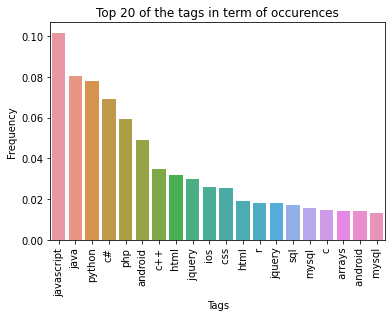

In [24]:
top = 20
options = {
    "title" : "Top {} of the tags in term of occurences".format(top),
    "xlabel": "Tags",
    "ylabel": "Frequency"
}

tmp = tags.sort_values(by ="count",ascending = False).head(top)
tmp["count"] = tmp["count"] / count_posts

fig, ax = plt.subplots(1);
sns.color_palette("viridis", as_cmap=True)
sns.barplot(x="tags", y="count", data=tmp, ax=ax)
ax.set(**options);
plt.xticks(rotation=90);

In [27]:
deduced_languages = tmp['tags']


cleaned_post = cleaned_post.withColumn('language_deduced', data_transfo.udf_detect_language(deduced_languages)(F.col('Splitted_tags')))

In [28]:
languages = (
    cleaned_post
    .select("Id", 
            F.explode('Splitted_tags').alias("tags"),
            "language_deduced"
           )
    .filter(F.col("language_deduced") != F.col("tags") )
    .groupBy('language_deduced','tags')
    .count()
    .toPandas()
)


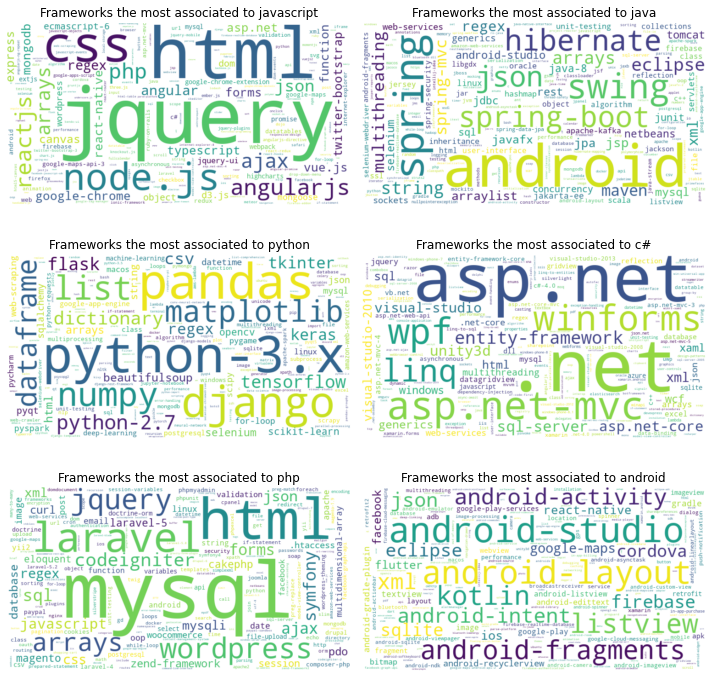

In [30]:
top = 6 
lang_to_plot = deduced_languages.iloc[:top]
wc = WordCloud(background_color='white', width=750, height=400)

fig, ax = plt.subplots(top//2, 2, figsize =(10,10))
i=0
j=0
for lang in lang_to_plot:
    tmp = (languages
           .loc[languages['language_deduced'] == lang, ['tags', 'count']]
           .set_index('tags')
           ).to_dict()['count']
    wc.fit_words(tmp)
    ax[i, j].imshow(wc, interpolation='bilinear')
    ax[i, j].axis("off")
    ax[i, j].set_title("Frameworks the most associated to {}".format(lang))
    if j==1:
        j=0
        i+=1
    else:
        j+=1
plt.tight_layout()

### Dates of the posts

In [31]:
cleaned_post = (
    cleaned_post
    .withColumn("CreationDate",F.to_timestamp(F.regexp_replace(F.col("CreationDate"),"T"," "),
                        "yyyy-MM-dd HH:mm:ss.SSS")
         .alias("CreationDate"))
)


<Figure size 432x288 with 0 Axes>

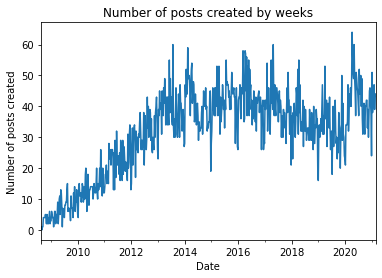

In [32]:
time = (
    cleaned_post
    .select(F.to_date("CreationDate").alias('date'))
    .groupBy('date')
    .count()
).toPandas()


options = {
    "title" : "Number of posts created by weeks",
    "xlabel": "Date",
    "ylabel": "Number of posts created"
}

fig = plt.figure();
time['date'] = time['date'].astype('datetime64')
time = time.set_index('date').resample("1W").sum()
ax = time.plot();
ax.get_legend().remove();
ax.set(**options);

### Scores distributions

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Boxplot')

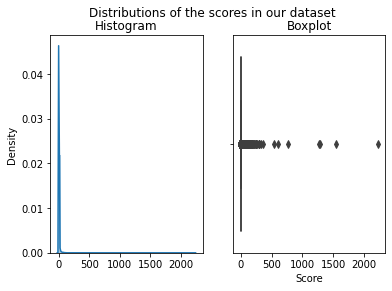

In [34]:
scores = (
    cleaned_post
    .select(F.col('Score').cast("int"))
    .toPandas()
)

fig, ax = plt.subplots(1,2)
plt.suptitle("Distributions of the scores in our dataset")
sns.distplot(scores, ax=ax[0])
ax[0].set_title("Histogram")


sns.boxplot(scores["Score"], ax=ax[1], orient = 'h')
ax[1].set_title("Boxplot")


## Users 

In [110]:
users.cache().count()

1071921

In [44]:
def country_name_to_ISO3(country):
    """
    Transforms country name into country ISO3 format
    """
    try:
        cn_a2_code =  country_name_to_country_alpha3(country)
    except:
        cn_a2_code = None
    return(cn_a2_code)

users_by_country = (
    users
    .select("Id","Location","Reputation")
    .join(country, on=['Location'], how='left')
    .groupby('Country')
    .count()).toPandas()

users_by_country["country_code"] = users_by_country["Country"].apply(country_name_to_ISO3)

gdf = data_loader.get_country_polygon()[[ 'ADM0_A3', 'geometry']]
gdf.columns = ['country_code', 'geometry']
users_by_country = gdf.merge(users_by_country, on = "country_code",how = "left").fillna({'count':0,'Country':'N/A'})
users_by_country.head()

,country_code,geometry,Country,count
0,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,19.0
1,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,116.0
2,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",N/A,0.0
3,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,13750.0
4,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States,84923.0


In [48]:
merged_json = json.loads(users_by_country.to_json())
json_data = json.dumps(merged_json)

In [52]:
from bokeh.io import output_notebook, show, output_file
p = data_transfo.plot_map(json_data,"Posts users number according to the country.", "count",0,10000)
show(p)

Loading BokehJS ...